# try to implement  
## "Towards End-to-End Speech Recognition with Deep Convolutional Neural Networks"

In [1]:
!nvidia-smi | head -n 31

Mon Feb  5 12:53:22 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:04:00.0 Off |                    0 |
| N/A   39C    P0    58W / 149W |    473MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:05:00.0 Off |                    0 |
| N/A   32C    P0    71W / 149W |    141MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [6]:
SAMPLE_RATE = 16000
WINDOW_SIZE = .02
WINDOW_STRIDE = .01
WINDOW = 'hamming'

HIDDEN_LAYERS = 3
#RNN_TYPE = supported_rnns['gru']
BIDIRECTIONAL = True

BEGINING_LEARNING_RATE = 3e-5
MOMENTUM = 0.9
MAX_NORM = 3
#LABELS = ''.join(data_utils.LABELS)
BATCH_SIZE = 32

GPU_CORES = ['/gpu:0','gpu:1']
gpu_num = len(GPU_CORES)
REMOTE_WORKER = "grpc://10.109.246.8:2224"
RNN_SIZE = 256#768
DROPOUT = 0.2
MODEL_NAME = "2_5-LAS-real-opt"
OUTPUT_MAX_LENGTH = 300
#audio_conf = dict(sample_rate=SAMPLE_RATE,
#                  window_size=WINDOW_SIZE,
#                  window_stride=WINDOW_STRIDE,
#                  window=WINDOW,
#                )

In [3]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(i) for i in GPU_CORES])

In [4]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../common/')
import data_utils
import editdistance as eds
import utils
from utils import Dataset,ProgressBar
import tflearn
from tflearn.data_flow import DataFlow,DataFlowStatus,FeedDictFlow
#from model import DeepSpeech,supported_rnns
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow.python.layers import core as layers_core
#import sugartensor as tf
import re
import pypinyin
from pypinyin import pinyin, lazy_pinyin, Style
import time

In [7]:
np.zeros([3,2]).size

6

## The implemention of pytorch's DataLoader is not competiable with tflearn's DataFlow
```python
train_loader = data_utils.AudioDataLoader(
    data_utils.SpectrogramDataset(manifest_filepath='./data/ted_train_manifest_fix.csv')
    ,batch_size=16,shuffle=True)

test_loader = data_utils.AudioDataLoader(
    data_utils.SpectrogramDataset(manifest_filepath='./data/ted_test_manifest_fix.csv')
    ,batch_size=16,shuffle=True)
```

In [8]:
import pickle
with open('../data/dics.pkl','rb') as fhdl:
    ch2ind,ind2ch = pickle.load(fhdl)

In [9]:
with open('../data/pinyins.pkl','rb') as whdl:
    py2ind,ind2py = pickle.load(whdl)

In [10]:
py2ind['<go>'] = len(py2ind)
ind2py[len(ind2py)] = '<go>'

py2ind['<eos>'] = len(py2ind)
ind2py[len(ind2py)] = '<eos>'

In [11]:
import flow_tools

In [12]:
ch2py = lambda x:" ".join([i[0] for i in pinyin(x)])

# CONFIG

In [13]:
#voice_dataset_train = data_utils.VoicesFlow(manifest_filepath='./data/ted_train_manifest_fix.csv')
#voice_flow_train = data_utils.get_flow(voice_dataset_train,shuffle=True,batch_size=BATCH_SIZE)
#
#voice_dataset_test = data_utils.VoicesFlow(manifest_filepath='./data/ted_test_manifest_fix.csv')
#voice_flow_test = data_utils.get_flow(voice_dataset_test,shuffle=False,batch_size=BATCH_SIZE)

voice_dataset_train = data_utils.VoicesFlow(manifest_filepath='../data/csvs/train_len.csv',mfcc=False,phon=False,labels=list(ch2ind.keys()),ch2ind=ch2ind,ind2ch=ind2ch)#,phm_dict_file='./data/TEDLIUM_release1/TEDLIUM.150K.dic')
voice_flow_train = utils.SortedEfficientFlowWrapper(voice_dataset_train,batch_size=BATCH_SIZE * gpu_num,shuffle=False)

voice_dataset_test = data_utils.VoicesFlow(manifest_filepath='../data/csvs/dev_len.csv',mfcc=False,phon=False,labels=list(ch2ind.keys()),ch2ind=ch2ind,ind2ch=ind2ch)#,phm_dict_file='./data/TEDLIUM_release1/TEDLIUM.150K.dic')
voice_flow_test = utils.SortedEfficientFlowWrapper(voice_dataset_test,batch_size=BATCH_SIZE * gpu_num,shuffle=False)

In [14]:
voice_flow_train_shu = utils.SortedEfficientFlowWrapper(voice_dataset_train,batch_size=BATCH_SIZE * gpu_num,shuffle=True)
voice_flow_test_shu = utils.SortedEfficientFlowWrapper(voice_dataset_test,batch_size=BATCH_SIZE * gpu_num,shuffle=True)

shuffle
shuffle


In [15]:
import sys

In [16]:
len(voice_dataset_train),len(voice_dataset_test)

(119338, 14326)

In [17]:
from utils import Dataset

In [18]:
start = time.time()
a,b,c,d,e = voice_flow_train.next_batch(BATCH_SIZE)
time.time() - start

0.2842094898223877

In [19]:
chstr = ''.join([ind2ch[i] for i in b[0]])

In [20]:
chstr,pinyin(chstr)

('娱乐频道', [['yú'], ['lè'], ['pín'], ['dào']])

In [21]:
a.shape

(64, 161, 176, 1)

娱乐频道
../data/data_aishell/wav_uncompress/train/S0141/BAC009S0141W0423.wav
../data/transcript/BAC009S0141W0423.txt
124


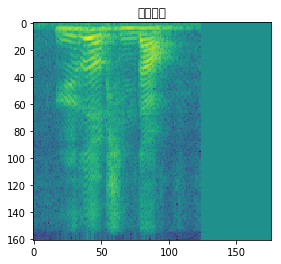

In [22]:
index = 0
#plt.figure(figsize=(30,50))
plt.imshow(a[index,:,:,0])
plt.title(''.join(ind2ch[i] for i in b[index]))
print(''.join(ind2ch[i] for i in b[index]))
print(c[index])
print(d[index])
print(e[index])

In [23]:
import IPython.display as ipd

In [24]:
print(open(d[index],encoding='utf-8').read())
ipd.Audio(c[index])

娱乐频道


In [25]:
def chind2pyind(inputs):
    out = []
    for one in inputs:
        sent = ''.join([ind2ch[i] for i in one])
        outone = ch2py(sent)
        oneoutind = [py2ind.get(i,0) for i in outone]
        out.append(oneoutind)
    return out

In [26]:
''.join([ind2py[i] for i in chind2pyind(b)[0]])

'yú lè pín dào'

# convert data to numpy format

In [27]:
tf.__version__

'1.2.1'

In [28]:
def listener(input_tensor,layer_num,rnn_seq_lens,rnn_size,training,name="googleLAS"):
    """
        input should be like [batch_size,time,freq * filters]
    """
    with tf.variable_scope(name):
        net = input_tensor
        for i in range(layer_num):
            with tf.variable_scope("{}_layer{}".format(name,i + 1)):
                forward_cell = tf.contrib.rnn.BasicLSTMCell(rnn_size)
                backward_cell = tf.contrib.rnn.BasicLSTMCell(rnn_size)
            #bi_outputs, bi_encoder_state,_ = tf.contrib.rnn.static_bidirectional_rnn(
            #        forward_cell,backward_cell,tf.unstack(net,net_shape[1],1),dtype=tf.float32)

                bi_outputs, bi_encoder_state = tf.nn.bidirectional_dynamic_rnn(
                            forward_cell, backward_cell, net,
                            sequence_length = rnn_seq_lens,time_major = False,dtype=tf.float32)
                outputs_fw, outputs_bw = bi_outputs
                rnn_outputs = outputs_fw + outputs_bw
                #rnn_outputs = tf.layers.batch_normalization(rnn_outputs, training=training)
                net = rnn_outputs
                if i != layer_num -1:
                    print('reduced once')
                    net = tf.concat((net[:,::2,:],net[:,1::2,:]),axis=-1)
                final_state = bi_encoder_state
        print()
        final_state = tf.concat([final_state[0][0], final_state[1][0]], axis=1)
        return net,final_state
    

def _activation_summary(act,tensor_name):
    """Helper to create summaries for activations.
    Creates a summary that provides a histogram of activations.
    Creates a summary that measure the sparsity of activations.
    Args:
      act: Tensor
    """
    # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
    # session. This helps the clarity of presentation on tensorboard.
    tf.summary.histogram(tensor_name + '/activations', act)
    tf.summary.scalar(tensor_name + '/sparsity', tf.nn.zero_fraction(act))
    
def _image_summary(img,tensor_name):
    tf.summary.image(tensor_name,img)

In [29]:
list(range(2,3))

[2]

In [30]:
GPU_CORES

['/gpu:0', 'gpu:1']

In [31]:
def average_gradients(tower_grads):
    """Calculate the average gradient for each shared variable across all towers.
    Note that this function provides a synchronization point across all towers.
    Args:
    tower_grads: List of lists of (gradient, variable) tuples. The outer list
      is over individual gradients. The inner list is over the gradient
      calculation for each tower.
    Returns:
     List of pairs of (gradient, variable) where the gradient has been averaged
     across all towers.


    """
    average_grads = []
    for grad_and_vars in zip(*tower_grads):
        # Note that each grad_and_vars looks like the following:
        #   ((grad0_gpu0, var0_gpu0), ... , (grad0_gpuN, var0_gpuN))
        grads = []
        for g, _ in grad_and_vars:
            # Add 0 dimension to the gradients to represent the tower.
            expanded_g = tf.expand_dims(g, 0)
            # Append on a 'tower' dimension which we will average over below.
            grads.append(expanded_g)

        # Average over the 'tower' dimension.
        grad = tf.concat(grads,0)
        grad = tf.reduce_mean(grad, 0)

        # Keep in mind that the Variables are redundant because they are shared
        # across towers. So .. we will just return the first tower's pointer to
        # the Variable.
        v = grad_and_vars[0][1]
        grad_and_var = (grad, v)
        average_grads.append(grad_and_var)
    return average_grads

def dense_to_sparse(a_t):
    idx = tf.where(tf.not_equal(a_t, py2ind['<eos>']))
    # Use tf.shape(a_t, out_type=tf.int64) instead of a_t.get_shape() if tensor shape is dynamic
    sparse = tf.SparseTensor(idx, tf.gather_nd(a_t, idx), a_t.get_shape())
    return sparse

In [32]:
list(enumerate(GPU_CORES))

[(0, '/gpu:0'), (1, 'gpu:1')]

In [36]:
assert(len(GPU_CORES) <= 4)
gpu_num = len(GPU_CORES)
tf.reset_default_graph()

graph = tf.Graph()
with graph.as_default():
    initializer = tf.truncated_normal_initializer(
        mean=0.0,stddev=0.02)
    tf.get_variable_scope().set_initializer(initializer)
    

    input_sound = tf.placeholder(tf.float32,shape=[BATCH_SIZE * gpu_num,161,None])
    targetsall = tf.placeholder(tf.int32,shape=[BATCH_SIZE * gpu_num,None])
    y_in = tf.placeholder("int32",[BATCH_SIZE * gpu_num,None])
    y_len =  tf.placeholder(tf.int32, shape=(BATCH_SIZE * gpu_num))
    y_real_len =  tf.placeholder(tf.int32, shape=(BATCH_SIZE * gpu_num))
    sentence_max_length = tf.constant(OUTPUT_MAX_LENGTH)
    # [batch_size,freq,time,1]

    voicelength = tf.placeholder(tf.int32, shape=(BATCH_SIZE * gpu_num))
    global_step = tf.train.get_or_create_global_step()
    max_grad = tf.placeholder(tf.float32)
    
    #, shape=np.array([BATCH_SIZE,4], dtype=np.int64))

    learning_rate = tf.placeholder(tf.float32)
    training=tf.placeholder(tf.bool)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    optimizer_sgd = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
    tower_gradients = []
    tower_gradients_sgd = []
    
    embedding_decoder = tf.get_variable(
        "embedding_decoder", [len(ind2py), RNN_SIZE],dtype=tf.float32)
    
    

with graph.as_default():
    with tf.variable_scope(tf.get_variable_scope()) as vscope:
        for ind,one_core in enumerate(GPU_CORES):
            print(ind)
            with tf.device("{}".format(one_core)):
                targets = targetsall[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE]
                net = input_sound[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE]
                
                net = tf.transpose(net,[0,2,1])
                net_shape = net.get_shape().as_list()
                #net = tf.reshape(net,[BATCH_SIZE,-1,net_shape[-1] * net_shape[-2]])
                # [batch_size,time,freq * filters]
                rnn_out,rnn_out_state = listener(net,HIDDEN_LAYERS,voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE],RNN_SIZE,training=training,name="deepspeech_rnn_layer")
                
                with tf.variable_scope("attend_and_spell"):
                    decoder_emb_inp = tf.nn.embedding_lookup(
                        embedding_decoder, y_in[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE])
                    cell_list = []
                    for i in range(2):
                        cell_list.append(
                            #tf.contrib.rnn.DropoutWrapper(
                            tf.contrib.rnn.BasicLSTMCell(RNN_SIZE)#, input_keep_prob=(1.0 - DROPOUT)
                            #)
                        )
                    if len(cell_list) == 1:
                        decoder_cell = cell_list[0]
                    else:
                        decoder_cell = tf.contrib.rnn.MultiRNNCell(cell_list)

                    # Helper

                    # attention
                    attention_mechanism = tf.contrib.seq2seq.LuongAttention(
                        RNN_SIZE, rnn_out,
                        memory_sequence_length=voicelength[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE] // 4,scale=True)
                    decoder_cell = tf.contrib.seq2seq.AttentionWrapper(
                        decoder_cell, attention_mechanism,
                        attention_layer_size=RNN_SIZE)

                    projection_layer = layers_core.Dense(
                        len(ind2py), use_bias=False)
                
                # Dynamic decoding
                with tf.variable_scope("decode_layer"):
                    helper = tf.contrib.seq2seq.TrainingHelper(
                        decoder_emb_inp,sequence_length= y_len[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE])
                    decoder = tf.contrib.seq2seq.BasicDecoder(
                        decoder_cell, helper, initial_state = decoder_cell.zero_state(dtype=tf.float32,batch_size=BATCH_SIZE),
                        output_layer=projection_layer)

                    outputs, _,___  = tf.contrib.seq2seq.dynamic_decode(decoder)
                    logits = outputs.rnn_output

                    target_weights = tf.sequence_mask(
                        y_real_len[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE], y_len[ind * BATCH_SIZE], dtype=logits.dtype)
                
                # predicting
                # Helper
                with tf.variable_scope("decode_layer", reuse=True):
                    helper_predict = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                        embedding_decoder,
                        tf.fill([BATCH_SIZE], py2ind['<go>']), py2ind['<eos>'])
                    decoder_predict = tf.contrib.seq2seq.BasicDecoder(
                        decoder_cell, helper_predict, initial_state = decoder_cell.zero_state(dtype=tf.float32,batch_size=BATCH_SIZE),
                        output_layer=projection_layer)
                    outputs_predict,_, __ = tf.contrib.seq2seq.dynamic_decode(
                        decoder_predict, maximum_iterations=sentence_max_length)
                translations = outputs_predict.sample_id
                
                crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
                    labels=targetsall[ind * BATCH_SIZE:(ind + 1) * BATCH_SIZE], logits=logits)
                train_loss = (tf.reduce_sum(crossent * target_weights) /
                    BATCH_SIZE)
                with tf.variable_scope("Train", reuse=True):
                    tf.summary.scalar("train_loss",train_loss)
                    tf.summary.scalar("train_batch_length",tf.reduce_mean(y_real_len))
                    tf.summary.scalar("train_voice_length",tf.reduce_mean(voicelength))

                trainable_params = tf.trainable_variables()
                #trainable_params = [i for i in trainable_params if
                #                    ('deepspeech' in i.name and 'Minimum_grad' not in i.name)]
                #grads_e = optimizer.compute_gradients(ctc_loss, var_list = trainable_params)
                #grads_e_sgd = optimizer_sgd.compute_gradients(ctc_loss, var_list = trainable_params)
                #gradients = tf.gradients(ctc_loss, trainable_params)
                #clip_gradients, _ = tf.clip_by_global_norm(gradients, max_grad)
                #clip_gradients_sgd, _ = tf.clip_by_global_norm(gradients, max_grad)
                #L_loss = tf.clip_by_value(loss, -max_grad, max_grad)
                L_loss = train_loss
                tf.get_variable_scope().reuse_variables()
                #train_op = optimizer.minimize(loss,global_step=global_step)
                #train_op = optimizer.apply_gradients(
                #        zip(clip_gradients, trainable_params), global_step=global_step)
                grads_e_ori = optimizer.compute_gradients(L_loss, var_list = trainable_params)
                grads_e_ori = [i[0] for i in grads_e_ori]
                #grads_e, _ = tf.clip_by_global_norm(grads_e_ori, max_grad)
                grads_e = grads_e_ori
                grads_e_sgd_ori = optimizer_sgd.compute_gradients(L_loss, var_list = trainable_params)
                grads_e_sgd_ori = [i[0] for i in grads_e_sgd_ori]
                #grads_e_sgd, _ = tf.clip_by_global_norm(grads_e_sgd_ori, max_grad)
                grads_e_sgd = grads_e_sgd_ori
                tower_gradients.append(zip(grads_e,trainable_params))
                tower_gradients_sgd.append(zip(grads_e_sgd,trainable_params))
                print('finish {}'.format(ind))


with graph.as_default():
    summary_op = tf.summary.merge_all()
    train_summary_writer = tf.summary.FileWriter("./log/compair/{}".format(MODEL_NAME), graph)
        
    grads = average_gradients(tower_gradients)
    grads_sgd = average_gradients(tower_gradients_sgd)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.apply_gradients(grads,global_step)
        train_op_sgd = optimizer_sgd.apply_gradients(grads_sgd,global_step)
        
    with tf.variable_scope("Train"):
        editdistance_train = tf.placeholder(tf.float32)
        editdistance_op_train = tf.summary.scalar("EditDistance",editdistance_train)
    with tf.variable_scope("Validation"):
        test_loss = tf.placeholder(tf.float32)
        loss_op = tf.summary.scalar("Accuracy",test_loss)
        editdistance = tf.placeholder(tf.float32)
        editdistance_op = tf.summary.scalar("EditDistance",editdistance)
    test_op = tf.summary.merge([loss_op,editdistance_op])


0
reduced once
reduced once

finish 0
1
reduced once
reduced once

finish 1


In [37]:
tf.__version__

'1.2.1'

In [38]:
rnn_out

<tf.Tensor 'deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer3/add:0' shape=(32, ?, 256) dtype=float32>

In [39]:
net

<tf.Tensor 'transpose_1:0' shape=(32, ?, 161) dtype=float32>

In [40]:
BATCH_SIZE

32

In [41]:
grads_e[:2]

 <tf.Tensor 'gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer1/bidirectional_rnn/fw/fw/while/fw/basic_lstm_cell/basic_lstm_cell/MatMul/Enter_grad/b_acc_3:0' shape=(417, 1024) dtype=float32>]

In [42]:
grads_e_ori[:2]

 <tf.Tensor 'gradients_2/deepspeech_rnn_layer_1/deepspeech_rnn_layer_layer1/bidirectional_rnn/fw/fw/while/fw/basic_lstm_cell/basic_lstm_cell/MatMul/Enter_grad/b_acc_3:0' shape=(417, 1024) dtype=float32>]

In [43]:
with graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(config=config)
    
    sess.run(tf.global_variables_initializer())
    tf.train.global_step(sess, global_step)

In [44]:
import os
if not os.path.exists("models/{}".format(MODEL_NAME)):
    os.mkdir("models/{}".format(MODEL_NAME))

In [45]:
with graph.as_default():
    saver = tf.train.Saver()
    saver.save(sess,'models/{}/sample'.format(MODEL_NAME))

In [46]:
allmodels = [i  for i in os.listdir('models/{}'.format(MODEL_NAME)) if ('meta' in i and 'model' in i)]

In [47]:
epochs = [int(i[-6]) for i in allmodels]

In [48]:
MODEL_NAME

'2_5-LAS-real-opt'

In [49]:
N_BATCH = len(voice_dataset_train) // (BATCH_SIZE * gpu_num)
N_BATCH_TEST = len(voice_dataset_test) // (BATCH_SIZE * gpu_num)

In [50]:
batch_x,batch_y_ori,s,a,t = voice_flow_train.next_batch(BATCH_SIZE)

In [51]:
batch_x.shape

(64, 161, 191, 1)

In [52]:
if epochs:
    train_epoch = max(epochs) + 1
else:
    train_epoch = 1

In [53]:
train_batch = 1

In [54]:
train_epoch

1

In [55]:
len(voice_dataset_train)

119338

In [56]:
BATCH_SIZE

32

In [57]:
N_BATCH

1864

In [58]:
def alignx(inputx):
    tmp = inputx.reshape((-1,inputx.shape[2]))
    tmp = tf.contrib.keras.preprocessing.sequence.pad_sequences(tmp,padding='post',maxlen= ((tmp.shape[1] - 1) // 8 + 1) * 8,dtype=np.float32,value=0)
    #print(tmp)
    return np.reshape(tmp,(inputx.shape[0],inputx.shape[1],-1))

In [59]:
def arr2target(inputy):
    return tf.contrib.keras.preprocessing.sequence.pad_sequences(inputy,padding='post',value=py2ind['<eos>'],maxlen=max([len(i) for i in inputy]) + 1)

In [60]:
def arr2input(inputy):
    return np.concatenate([np.expand_dims(np.asarray([py2ind['<go>']] * len(inputy)),axis=-1),tf.contrib.keras.preprocessing.sequence.pad_sequences(inputy,padding='post',value=py2ind['<eos>'],maxlen=max([len(i) for i in inputy]))],axis=-1)

In [61]:
addone = lambda x:[i + 1 for i in x]

In [62]:
start = time.time()
a,b,c,d,e = voice_flow_train.next_batch(BATCH_SIZE)
time.time() - start

0.32291603088378906

In [63]:
a.shape

(64, 161, 199, 1)

In [64]:
alignx(a[:,:,:,0]).shape,a[:,:,:,0].shape

((64, 161, 200), (64, 161, 199))

In [65]:
a.shape

(64, 161, 199, 1)

In [66]:
voice_flow_train = voice_flow_train_shu

In [67]:
restore = True
N_EPOCH = 50
DECAY_EPOCH = 6
import traceback


        
expdis = utils.ExpVal()
exploss = utils.ExpVal()
clk = utils.Tick()

begining_learning_rate = BEGINING_LEARNING_RATE
clip_norm = 400
with graph.as_default():
    if restore == False:
        train_epoch = 1
        train_batch = 0
    for one_epoch in range(train_epoch,N_EPOCH):
        if one_epoch >= 2:
            voice_flow_train = voice_flow_train_shu
        train_epoch = one_epoch
        pb = ProgressBar(worksum=N_BATCH * BATCH_SIZE * gpu_num,info=" epoch {} batch {}".format(train_epoch,train_batch))
        pb.startjob()

        for one_batch in range(N_BATCH):
            if restore == True and one_batch < train_batch:
                pb.auto_display = False
                pb.complete(BATCH_SIZE * gpu_num)
                pb.auto_display = True
                continue
            else:
                restore = False
            train_batch = one_batch

            clk.tick()
                    
            batch_lr = begining_learning_rate * 2 ** -(max(one_epoch-DECAY_EPOCH + 1,0) // 2)
            batch_x,batch_y,_,__,batch_voicelen = voice_flow_train.next_batch(BATCH_SIZE * gpu_num)
            batch_y = chind2pyind(batch_y)
            batch_x = np.nan_to_num(batch_x,0)
            batch_x = alignx(batch_x[:,:,:,0])
            
            batch_target = arr2target(batch_y)
            batch_yin = arr2input(batch_y)
            batch_ylen = [batch_target.shape[1]] * (BATCH_SIZE * gpu_num)
            batch_yreallen = addone([len(i) for i in batch_y])
            feeddic = {
                input_sound: batch_x,
                targetsall:batch_target,
                y_in:batch_yin,
                y_len:batch_ylen,
                y_real_len:batch_yreallen,
                voicelength:batch_voicelen,
                learning_rate:batch_lr,
                training:True,
            }
            t1 = clk.tock()
            clk.tick()
            try:
                _,batch_translation,step_loss,step_summary,step_value = sess.run(
                    [train_op,translations,train_loss,summary_op,global_step],feed_dict=feeddic)
            except (KeyboardInterrupt,SystemExit):
                raise
            except:
                traceback.print_exc()
                dd
                continue
            
            batch_editdistances = []
            for x,y in zip(batch_translation,batch_target):
                one_dis = eds.eval(x,y)
                one_dis = one_dis / max(len(x),len(y))
                batch_editdistances.append(one_dis)
                
            batch_editdistances = np.average(batch_editdistances)
            batch_editdistance_op_train = sess.run(editdistance_op_train,feed_dict={editdistance_train:batch_editdistances})
            
            expdis.update(batch_editdistances)
            exploss.update(step_loss)
            t2 = clk.tock()
            pb.info = "EPOCH {} STEP {} LR {} LOSS {} DIS {} t1 {} t2 {}".format(one_epoch,one_batch,batch_lr,exploss.getval(),expdis.getval(),t1,t2)
            train_summary_writer.add_summary(step_summary,step_value)
            train_summary_writer.add_summary(batch_editdistance_op_train,step_value)
            pb.complete(BATCH_SIZE * gpu_num)
        
        saver = tf.train.Saver(tf.global_variables())
        saver.save(sess,"models/{}/model_{}".format(MODEL_NAME,one_epoch))

EPOCH 1 STEP 81 LR 3e-05 LOSS nan DIS 0.96 t1 2.23 t2 2.95 4.40 % [==>------------------------------------------------] 5248/119296 	 used:330s eta:7182 s

KeyboardInterrupt: 

In [ ]:
batch_translation

In [ ]:
with graph.as_default():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    sess = tf.Session(config=config)
    
    sess.run(tf.global_variables_initializer())
    tf.train.global_step(sess, global_step)

In [ ]:
batch_target.shape

In [99]:
batch_lr = 3e-3 * 2 ** -(max(1-10 + 1,0) // 2)
batch_x,batch_y,_,__,batch_voicelen = voice_flow_train.next_batch(BATCH_SIZE * gpu_num)
batch_y = chind2pyind(batch_y)
batch_x = np.nan_to_num(batch_x,0)
batch_x = alignx(batch_x[:,:,:,0])
batch_target = arr2target(batch_y)
batch_yin = arr2input(batch_y)
batch_ylen = [batch_target.shape[1]] * (BATCH_SIZE * gpu_num)
batch_yreallen = addone([len(i) for i in batch_y])
feeddic = {
    input_sound: batch_x,
    targetsall:batch_target,
    y_in:batch_yin,
    y_len:batch_ylen,
    y_real_len:batch_yreallen,
    voicelength:batch_voicelen,
    learning_rate:batch_lr,
    training:True,
}

In [100]:
feeddic[learning_rate] = 3e-4

In [101]:
batch_lr

0.003

In [110]:
bb = sess.run(translations,feed_dict=feeddic)

In [116]:
bb.shape

(32, 300)

In [117]:
batch_target.shape

(32, 44)

In [120]:
editdistance.eval([1,2,3,4],[1,2,4])

1

In [108]:
import editdistance

In [183]:
sess.run(rnn_out,feed_dict=feeddic).shape

(32, 296, 256)

In [228]:
for i in range(100):
    sess.run(train_op,feed_dict=feeddic)
    print(sess.run(train_loss,feed_dict=feeddic))

163.153
162.553
161.009
157.616
151.842


KeyboardInterrupt: 

In [98]:
batch_x.shape

(64, 161, 288)

In [ ]:
batch_xx,batch_y_ori1,s1,a1,t1 = voice_flow_train.next(1)['data']

In [ ]:
batch_xx.shape,BATCH_SIZE

In [ ]:
start = time.time()
step_dis,step_loss,step_value = sess.run(
                    [dis,loss,global_step],feed_dict=feeddic)
print(time.time() - start)

In [ ]:
DECAY_EPOCH = 10
begining_learning_rate = BEGINING_LEARNING_RATE
for one_epoch in range(1,30):
    print(begining_learning_rate * 2 ** -(max(one_epoch-DECAY_EPOCH,0)))

In [ ]:
1